In [3]:
GROQ_API_KEY = ""

In [9]:
from groq import Client

client = Client(api_key=GROQ_API_KEY)

In [10]:
def prompt_template(content):
    return [{"role": "user", "content": content}]

In [11]:
from metric_prompts.faithfulness import faithfulness_prompt
from metric_prompts.answer_relevancy import answer_relevancy_prompt
from ratelimit import limits, sleep_and_retry

RATE_LIMIT = 30
TIME_PERIOD = 180

@sleep_and_retry
@limits(calls=RATE_LIMIT, period=TIME_PERIOD)
def api_call(client, message, model):
    response = client.chat.completions.create(messages=message, model=model)
    return response.choices[0].message.content


def faithfulness(judge, query, context, output):
    judge_statement = judge.chat.completions.create(
        messages=prompt_template(faithfulness_prompt(context, query, output)),
        model="llama3-70b-8192",
    )
    return judge_statement.choices[0].message.content

def answer_relevancy(judge, query, output):
    judge_statement = judge.chat.completions.create(
        messages=prompt_template(answer_relevancy_prompt(query, output)),
        model="llama3-70b-8192",
    )
    return judge_statement.choices[0].message.content

In [12]:
import pandas as pd
df = pd.read_parquet("./RAGtruth/data.parquet")
df = df[df["task_type"] == "QA"]

df["labels"] = df["labels"].apply(lambda x: False if len(x) == 0 else x)
df["labels"] = df["labels"].apply(lambda x: x[0]["label_type"] if type(x) != bool else x)

# Filter rows where labels are not False
df = df[df["labels"] != False]

def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
chunks_l = split_dataframe(df, chunk_size=100)

In [13]:
import pandas as pd
df = pd.read_parquet("./RAGtruth/data.parquet")
df = df[df["task_type"] == "QA"]

df["labels"] = df["labels"].apply(lambda x: False if len(x) == 0 else x)
df["labels"] = df["labels"].apply(lambda x: x[0]["label_type"] if type(x) != bool else x)
# df = df[df["model"].str.contains("llama")]
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
chunks = split_dataframe(df, chunk_size=100)

In [ ]:
import json
from tqdm import tqdm


STEP = 50
faithful_values = []
ar_values = []
temperature_values = []
ys = []

for i, (source_id, group) in enumerate(tqdm(df.groupby(df.index))):
    questions = group["question"].values[0]
    context = group["context"].values[0]
    responses = group["response"].values.tolist()
    temperatures = group["temperature"].values.tolist()
    labels = group["labels"].values.tolist()

    raw_json = faithfulness(client, questions, context, responses)
    raw_json = raw_json[raw_json.find("{"):raw_json.rfind("}")+1].replace("\\", "\\\\")
    try:
        parsed_json = json.loads(raw_json)
    except json.JSONDecodeError:
        print(raw_json)
        continue
    faithful_values.extend([parsed_json[f"answer_{j}"]["faithfulness"] for j in range(len(group))])
    raw_json = answer_relevancy(client, questions, responses)
    raw_json = raw_json[raw_json.find("{"):raw_json.rfind("}")+1].replace("\\", "\\\\")
    try:
        parsed_json = json.loads(raw_json)
    except json.JSONDecodeError:
        print(raw_json)
        continue
    ar_values.extend([parsed_json[f"answer_{j}"]["answer_relevancy"] for j in range(len(group))])

    temperature_values.extend(temperatures)
    ys.extend(labels)
    
    if (i + 1) % STEP == 0:
        pd.DataFrame([faithful_values, ar_values, temperatures, ys]).to_parquet(f"data_{(i + 1) // STEP}.parquet")


  0%|          | 0/989 [00:00<?, ?it/s]

['Unable to answer based on given passages.', 'Based on the given passages, it can be inferred that if someone cries at a sad movie, it could mean that they are emotionally moved or empathetic towards the characters and storyline.', 'Based on the given passages, crying at a sad movie does not necessarily indicate anything about a person\'s emotional state or their tendency to cry easily. Some people may cry readily at movies, while others may not. In passage 1, the speaker mentions that they cry at a variety of occasions, including weddings, birthday parties, school plays, and humane society advertisements featuring adoptable dogs. Passage 3 specifically mentions that the speaker cried deeply during both "The Notebook" and "The Source Code," despite not typically being someone who cries readily at personal problems or life events. Therefore, crying at a sad movie is simply a personal reaction and does not necessarily provide insight into a person\'s emotional state.', "Based on the pro

  0%|          | 1/989 [00:06<1:39:36,  6.05s/it]

['Remove the mushroom from the water and then drain well.', 'Unable to answer based on given passages.', 'To remove water from canned mushrooms, you need to follow these steps:\n\n1. Drain the mushrooms from the can and rinse them under running water to remove any remaining moisture.\n2. Pat the mushrooms dry with a paper towel or a clean kitchen cloth.\n3. Place the mushrooms on a baking sheet lined with parchment paper.\n4. Put the baking sheet in the oven at 200°F (93°C) for about an hour or until the mushrooms are completely dry.\n5. Once the mushrooms are dry, you can store them in an airtight container or freeze them for later use.', "Based on the provided passages, here's how you can remove water from canned mushrooms:\n\nPassage 1 states that after removing the mushrooms from the water, you should drain them well before placing them on a cookie sheet and freezing them for 30-40 minutes. This process will allow the excess water to evaporate, leaving the mushrooms dry and ready f

  0%|          | 3/989 [01:04<6:13:35, 22.73s/it]

{
  "answer_0": {
    "answer_only_asserts_no_document_answers": true,
    "content_analysis_sentence_by_sentence": [],
    "faithfulness_justification": "The answer only asserts that it is unable to answer the question based on the given passages, without providing any additional information.",
    "faithfulness": null
  },
  "answer_1": {
    "answer_only_asserts_no_document_answers": true,
    "content_analysis_sentence_by_sentence": [],
    "faithfulness_justification": "The answer only asserts that it is unable to answer the question based on the given passages, without providing any additional information.",
    "faithfulness": null
  },
  "answer_2": {
    "answer_only_asserts_no_document_answers": false,
    "content_analysis_sentence_by_sentence": [
      {
        "sentence": "1. Log into your Rollstone Bank account online.",
        "criterion_1": "No reference is provided",
        "criterion_2": "N/A",
        "criterion_3": "N/A"
      },
      {
        "sentence": "2. N

  0%|          | 4/989 [01:27<6:16:23, 22.93s/it]

{
"answer_0": {
"answer_only_asserts_no_document_answers": false,
"content_analysis_sentence_by_sentence": [
{
"sentence": "In golf, \\"clutch\\" refers to a putt that a player must make, especially in high-pressure situations.",
"criterion_1": "Yes, a reference follows the sentence.",
"criterion_2": "The reference is correct, passage 1 and passage 3.",
"criterion_3": "The sentence does not distort or modify the content of the references."
},
{
"sentence": "This could be a 6 foot par putt for an average golfer or a 10 footer to win a tournament or get into a playoff for a professional.",
"criterion_1": "Yes, a reference follows the sentence.",
"criterion_2": "The reference is correct, passage 1 and passage 3.",
"criterion_3": "The sentence does not distort or modify the content of the references."
}
],
"faithfulness_justification": "The answer accurately quotes the definitions of clutch putt from the references, and provides additional details that are in line with the context.",
"fait

  1%|          | 5/989 [02:24<9:36:41, 35.16s/it]

["Based on the passages, you should prepare for your G1 driver's test by taking practice tests, which are based on the official Ontario Driver's handbook. These tests will help you learn about road signs and rules, fines, and speed limits. It is also recommended to use resources like the #1 G1 Test Preparation Resource in Ontario. Remember, these tests are for practice purposes and passing them does not guarantee you will pass the actual G1 test.", "Based on the given passages, you should study the road signs, rules, fines, and speed limits mentioned in the Ontario Driver's handbook in preparation for your G1 drivers test. Additionally, you can use the collection of free Ontario G1 practice tests and quizzes provided to gain confidence and practice for the written road knowledge test.", "To prepare for your G1 drivers test in Ontario, it would be helpful to study the road signs and rules, fines, and speed limits. You can find practice tests online that are based on the official Ontario

  1%|          | 6/989 [03:35<12:56:31, 47.40s/it]

['To perform skill moves on FIFA 16 for Xbox One, you need to use combinations of buttons on your controller. For example, to do a Ball Juggle while your character is standing, hold LT and tap RB. Video guides showing what each skill move looks like are available at the top of the relevant page.', 'Passage 1 provides information on how to perform the Ball Juggle skill move on FIFA 16 for Xbox One. However, it does not provide information on other skill moves. \n\nUnable to answer based on given passages.', "To perform skill moves on FIFA 16 for Xbox One, hold down the LT button while tapping the RB button. This is the command for Ball Juggle when standing. For more information about all the skill moves in FIFA 16, refer to the skill moves tutorials available on the game's website or other resources.", "Based on the provided passages, here is how to perform skill moves on FIFA 16 for Xbox One:\n\n1. Ball Juggle (while standing): Press and hold the LT button on the Xbox controller, follo

  1%|          | 7/989 [04:20<12:40:38, 46.48s/it]

["The passages mention that Colorado has collected millions of dollars in tax revenue from the sale of marijuana. However, they do not specify what the state has done with the collected money. There is a mention of a possible refund due to a quirk in the state's constitution but it does not provide a definitive answer on how the state has used the money.", 'Colorado has collected tens of millions of dollars in tax revenue from marijuana sales, generating about $63 million in taxes in 2014 alone.', "Based on the given passages, it is clear that Colorado's legalization of recreational marijuana has generated significant tax revenue for the state. In the first month of sales, licensed dispensaries generated over $14 million and put about $2 million of tax revenue into state coffers (Passage 1). By the end of the first year, Colorado had collected tens of millions of dollars in taxes from pot (Passage 2). Furthermore, marijuana businesses in Colorado generated about $63 million in taxes in

  1%|          | 8/989 [05:16<13:29:43, 49.52s/it]

['Unable to answer based on given passages.', 'Unable to answer based on given passages.', 'To get an update for Lego Star Wars: The Complete Saga on iOS, you can either download it from the App Store or check for updates within the app. For Episode I Story Mode, you do not need to purchase anything as it is free for a limited time. However, for Episodes II through VI and other content, you will need to make in-app purchases. If you want to play Lego Star Wars: The New Yoda Chronicles, you will need to purchase it separately.', "Based on the provided passages, here's how to get the update for Lego Star Wars: The Complete Saga:\n\nTo get the update for Lego Star Wars: The Complete Saga, follow these steps:\n\n1. Download Lego Star Wars: The Complete Saga from the App Store for iOS devices. (Passage 1)\n2. Episode I: The Phantom Menace is included for free with the download, while the remaining five episodes are available through in-app purchases. (Passage 2)\n\nAlternatively, if you're 

  1%|          | 9/989 [06:02<13:14:30, 48.64s/it]

['Unable to answer based on given passages.', 'Unable to answer based on given passages.', "Based on the given passages, it is clear that the NHL quarter final schedule includes two games in Toronto and two games in Helsinki. The specific matchups are as follows:\n\n* In Toronto, Canada will play against either the fourth or third seed (depending on their position in the final round robin).\n* In Helsinki, Finland will play the evening game against either the second or first seed (again, depending on their position in the final round robin).\n\nIt's important to note that these matchups are subject to change based on the results of the final round robin and playoffs leading up to the quarter finals.", "Based on the provided passages, the NHL quarter-final schedule is as follows:\n\nCanada's quarter-final game will be played in Toronto at 8 p.m. ET. The specific match-ups and game times for the quarter-finals are not specified in the passages provided.", 'Based on the given passages, he

  1%|          | 10/989 [06:42<12:27:07, 45.79s/it]

['The chances of getting HIV after a single encounter vary depending on the type of sexual activity. For unprotected receptive anal sex, the risk is estimated to be 1.4%. For an HIV-negative woman having unprotected receptive vaginal sex, the risk could be closer to 1%. A study of heterosexual couples in Africa estimated the chance of catching the AIDS virus from a single sexual encounter with an infected person to be one in 588.', 'Based on the given passages, the chances of getting HIV after a single encounter are estimated to be 1.4% for receptive anal sex, 1% for receptive vaginal sex with a vaginal STI, and one in 588 for heterosexual encounters in Africa.', 'Based on the given passages, the chance of getting HIV after a single encounter varies depending on the type of sexual activity and the presence of a sexually transmitted infection (STI). For receptive anal sex, the estimated risk is 1.4%, while for receptive vaginal sex with a vaginal STI, the risk could be closer to 1%. How

  1%|          | 11/989 [07:43<13:45:32, 50.65s/it]

['Unable to answer based on given passages.', 'Unable to answer based on given passages.', 'Based on the given passages, it is clear that the Supreme Court played an important role in defining the laws and regulations related to slavery and citizenship rights during the Civil War era. The Dred Scott Decision, in particular, made a significant contribution to the ongoing debate over slavery and its legality in the United States. However, it is unclear what other roles the Supreme Court may have had during this time.', "Based on the provided passages, the Supreme Court played the following roles during the American Civil War:\n\n1. Defined its most influential role through the appeal process: According to passage 1, the Supreme Court's most significant role was established through the appeal process, which involved reviewing cases involving state and local legislatures, as well as Congress.\n2. Impacted by the Civil War: Passage 2 highlights the Supreme Court's experience during the Civi

  1%|          | 12/989 [08:31<13:32:16, 49.88s/it]

['Snails play several roles in the environment. They serve as a food source for various animals like birds, turtles, fishes, insects, and crocodiles. They also contribute to the cycling of organic matter, which helps to build healthy, rich soil. However, they can also be detrimental to plants.', 'Unable to answer based on given passages.', 'Unable to answer based on given passages.', 'Based on the provided passages, here is what snails do for the environment:\n\nUnable to answer based on given passages. Passages 1 and 2 focus primarily on controlling or exterminating snails, rather than highlighting their environmental benefits. Passage 3 provides some information about the ecological roles of slugs, but does not specifically mention snails. Therefore, I cannot provide an answer based on the given passages.', 'Based on the given passages, snails do not appear to provide any direct benefits to the environment. Passage 1 describes snails as being detrimental to plants, and passage 2 ment

  1%|▏         | 13/989 [09:10<12:36:15, 46.49s/it]

['Fluid in the knee, also known as knee effusion or water on the knee, is caused by an excessive accumulation of fluid around the knee joint. This can be due to various causes such as arthritis, injury to the ligaments or meniscus, or when fluid collects in the bursa. A small amount of fluid might be manageable with rest and elevation of the leg, while using a knee support to aid fluid drainage. However, a larger amount of fluid can make the knee joint tight, resulting in difficulty bending the leg.', 'The fluid in the knee can cause swelling and tightness in the knee joint, making it difficult to bend the leg.', 'Based on the given passages, fluid in the knee can cause swelling and tightness in the knee joint, making it difficult to bend the leg. However, small amounts of fluid can be drained through resting the leg, sitting with the leg raised, and wearing a knee support. Larger amounts of fluid may require medical attention.', "Based on the provided passages, here are some potential

  2%|▏         | 15/989 [10:29<11:14:53, 41.57s/it]

{
  "answer_0": {
    "answer_only_asserts_no_document_answers": false,
    "content_analysis_sentence_by_sentence": [
      {
        "sentence": "You can retrieve deleted web history on a PC by using a data recovery tool to recover these files, as they are saved on your PC’s hard drive just like other files.",
        "criterion_1": "yes",
        "criterion_2": "yes, passage 3",
        "criterion_3": "yes"
      },
      {
        "sentence": "Another method is to use Windows System Restore or Windows Registry, as Windows records user activities in log files.",
        "criterion_1": "yes",
        "criterion_2": "yes, passage 2",
        "criterion_3": "yes"
      }
    ],
    "faithfulness_justification": "All statements are faithful to the sources.",
    "faithfulness": 1
  },
  "answer_1": {
    "answer_only_asserts_no_document_answers": false,
    "content_analysis_sentence_by_sentence": [
      {
        "sentence": "You can retrieve deleted web history on a PC by using a dat

  2%|▏         | 17/989 [11:52<10:46:33, 39.91s/it]

{
  "answer_0": {
    "answer_only_asserts_no_document_answers": false,
    "content_analysis_sentence_by_sentence": [
      {
        "sentence": "To quickly get rid of mice, you need to take immediate action.",
        "criterion_1": "True",
        "criterion_2": "True",
        "criterion_3": "True" ([1])
      },
      {
        "sentence": "You can start by identifying all possible entry points that mice use to get into your house.",
        "criterion_1": "False",
        "criterion_2": "False",
        "criterion_3": "N/A"
      },
      {
        "sentence": "Once identified, consider putting steel wool inside these holes or vents before sealing them off.",
        "criterion_1": "True",
        "criterion_2": "True",
        "criterion_3": "True" ([2])
      },
      {
        "sentence": "This will prevent the mice from using these paths to re-enter your home.",
        "criterion_1": "True",
        "criterion_2": "True",
        "criterion_3": "True" ([2])
      },
      {

  2%|▏         | 19/989 [13:25<11:03:10, 41.02s/it]

{
"answer_0": {
"answer_only_asserts_no_document_answers": false,
"content_analysis_sentence_by_sentence": [
{
"sentence": "To change a Sim's appearance in Sims 4, you can use any mirror in the game.",
"criterion_1": "Reference is provided",
"criterion_2": "Reference 3",
"criterion_3": "Accurate"
},
{
"sentence": "Select the Sim you want to change, click on the mirror, and choose Change Appearance.",
"criterion_1": "Reference is provided",
"criterion_2": "Reference 3",
"criterion_3": "Accurate"
},
{
"sentence": "Your Sim will walk to the mirror, and a window will open allowing you to change their makeup, accessories, facial hair, and eyebrows.",
"criterion_1": "Reference is provided",
"criterion_2": "Reference 3",
"criterion_3": "Accurate"
},
{
"sentence": "You can also change the color of a Sim's eyebrows, stubble, and facial hair independently of the Sim's hair color.",
"criterion_1": "Reference is provided",
"criterion_2": "Reference 1",
"criterion_3": "Accurate"
},
{
"sentence": "A

  2%|▏         | 21/989 [14:49<10:44:09, 39.93s/it]

{
"answer_0": {
"answer_only_asserts_no_document_answers": true,
"content_analysis_sentence_by_sentence": [],
"faithfulness_justification": "The answer only states that it is unable to answer based on the given passages, without providing any related information.",
"faithfulness": null
},
"answer_1": {
"answer_only_asserts_no_document_answers": false,
"content_analysis_sentence_by_sentence": [
{
"sentence": "Accuracy of measurements: Errors in measuring height and weight can lead to inaccurate BMI calculations.",
"criterion_1": "No reference is provided for this statement.",
"criterion_2": "N/A",
"criterion_3": "N/A"
},
...
],
"faithfulness_justification": "None of the statements made by the answer are supported by the provided references.",
"faithfulness": 0
},
"answer_2": {
"answer_only_asserts_no_document_answers": true,
"content_analysis_sentence_by_sentence": [],
"faithfulness_justification": "The answer only states that it is unable to answer based on the given passages, without 

  2%|▏         | 23/989 [16:12<10:36:44, 39.55s/it]

{
"answer_0": {
"answer_only_asserts_no_document_answers": false,
"content_analysis_sentence_by_sentence": [
{
"sentence": "Republicans use a combination of winner-take-all and proportional allocation to allocate delegates in their presidential nominating procedure.",
"criterion_1": "yes",
"criterion_2": "passage 1",
"criterion_3": "correct"
}
],
"faithfulness_justification": "The response cites the correct passage and accurately summarizes the information.",
"faithfulness": 1
},
"answer_1": {
"answer_only_asserts_no_document_answers": false,
"content_analysis_sentence_by_sentence": [
{
"sentence": "Republicans use a combination of winner-take-all and proportional allocation to allocate delegates in their presidential nominating procedure.",
"criterion_1": "yes",
"criterion_2": "passage 1",
"criterion_3": "correct"
}
],
"faithfulness_justification": "The response cites the correct passage and accurately summarizes the information.",
"faithfulness": 1
},
"answer_2": {
"answer_only_asser

  3%|▎         | 25/989 [17:06<8:36:51, 32.17s/it] 

{
  "answer_0": {
    "answer_only_asserts_no_document_answers": true,
    "content_analysis_sentence_by_sentence": [],
    "faithfulness_justification": "The answer only asserts that no document responds to the question without providing any related information.",
    "faithfulness": null
  },
  "answer_1": {
    "answer_only_asserts_no_document_answers": true,
    "content_analysis_sentence_by_sentence": [],
    "faithfulness_justification": "The answer only asserts that no document responds to the question without providing any related information.",
    "faithfulness": null
  },
  "answer_2": {
    "answer_only_asserts_no_document_answers": false,
    "content_analysis_sentence_by_sentence": [
      {
        "sentence": "To tell if your camping gas bottle is empty, you can follow the instructions provided in passage 1: \\"How to check how much gas is left in your gas bottle\\".",
        "criterion_1": "Yes, a reference follows the sentence.",
        "criterion_2": "Yes, the refe

  3%|▎         | 26/989 [17:30<7:57:26, 29.75s/it]

{
    "answer_0": {
        "answer_only_asserts_no_document_answers": true,
        "content_analysis_sentence_by_sentence": [],
        "faithfulness_justification": "The answer only asserts that it is unable to answer based on the given passages without providing any related information.",
        "faithfulness": null
    },
    "answer_1": {
        "answer_only_asserts_no_document_answers": false,
        "content_analysis_sentence_by_sentence": [
            {
                "sentence": "Based on the information provided in the passages, pasta is unable to be classified as masculine or feminine in Italian.",
                "criterion_1": "Reference is not provided",
                "criterion_2": "N/A",
                "criterion_3": "N/A"
            }
        ],
        "faithfulness_justification": "The answer does not provide any reference to support its claim.",
        "faithfulness": 0
    },
    "answer_2": {
        "answer_only_asserts_no_document_answers": false,
   

  3%|▎         | 27/989 [18:30<10:21:58, 38.79s/it]

['Unable to answer based on given passages.', 'Unable to answer based on given passages.', 'Unable to answer based on given passages.', "Based on the provided passages, here are the three characteristics of Supreme Court nominees that are politically relevant during the appointment process:\n\nPassage 1:\n\n* Experience: Nominees' experience as a judge or lawyer has been a key factor in their confirmation. Senators often scrutinize a nominee's experience to determine their suitability for the position (Passage 1).\n* Ideology: Nominees' legal philosophy and judicial approach have been highly influential in shaping their political relevance during the appointment process. Interest groups often try to identify nominees who share their ideological views and use this information to influence the Senate's decision (Passage 1).\n* Diversity: The diversity of the nominee's background, including their race, gender, and personal history, has become an increasingly important factor in the appoin

  3%|▎         | 28/989 [19:28<11:53:38, 44.56s/it]

['Shares ex dividend refers to a classification of trading shares when a declared dividend belongs to the seller rather than the buyer. This occurs when a person has been confirmed by the company to receive the dividend payment. In order to be entitled to the dividend, a shareholder must have purchased the shares before the ex dividend date. If shares are purchased on or after the ex dividend date, the previous owner of the shares is entitled to the dividend, not the new purchaser.', 'Shares ex dividend refers to a classification of trading shares where the seller, rather than the buyer, is entitled to receive a declared dividend. This designation is given to stocks when the company confirms that a person will receive the dividend payment. The ex dividend date is the date on or after which the stock trades ex-dividend, meaning if shares are purchased on or after this date, the previous owner is entitled to the dividend, not the new owner.', 'Shares ex dividend mean that the shares are 

  3%|▎         | 29/989 [20:19<12:22:31, 46.41s/it]

['Whether or not you have to file a tax return for 2015 depends on several factors: your filing status (such as single or married filing jointly), how much you earned in gross income, the source of that income, your age, and whether or not you are a dependent of your parents.', 'Based on the given passages, you need to consider your filing status, income, and age to determine if you have to file taxes in 2015.', "Based on the given passages, it is difficult to definitively say whether or not someone has to file taxes for 2015. However, according to Passage 2, the main factors that generally determine whether someone needs to file taxes include their filing status, gross income, and whether they are a dependent of their parents. Passage 3 also mentions that a person's age may play a role in determining whether or not they are required to file a federal income tax return. It is recommended to consult with a tax professional or the IRS for more detailed guidance on this matter.", "Based o

  3%|▎         | 31/989 [21:41<11:18:42, 42.51s/it]

{
  "answer_0": {
    "answer_only_asserts_no_document_answers": false,
    "content_analysis_sentence_by_sentence": [
      {
        "sentence": "To write an email for leave, you should start with a clear subject line such as \\"Application of leave for 10 days.\\"",
        "criterion_1": "Reference provided",
        "criterion_2": "Reference correct (Passage 1)",
        "criterion_3": "Accurate representation of reference"
      },
      {
        "sentence": "The body of the email should be addressed respectfully, for example starting with \\"Sir,\\" or \\"Dear [recipient's name].\\"",
        "criterion_1": "No reference provided",
        "criterion_2": "Not applicable",
        "criterion_3": "Not applicable"
      },
      {
        "sentence": "In the email, specify the number of working days you wish to take off and the exact dates.",
        "criterion_1": "No reference provided",
        "criterion_2": "Not applicable",
        "criterion_3": "Not applicable"
      },
  

  3%|▎         | 32/989 [23:25<11:40:41, 43.93s/it]


APIConnectionError: Connection error.

In [9]:
from tqdm import tqdm

key = 16

def generate_df(key, chunks):
    for i in range(4, 6):
        print(i, "th chunk")
        print("faithfulness")
        chunks[key]["faithfulness"] = [faithfulness(client, row["question"], row["context"], row["response"]) for ind, row in tqdm(chunks[key].iterrows())]
        pd.DataFrame(chunks[key]["faithfulness"]).to_parquet(f"faithful_{key}_{i + 1}.parquet")
    for i in range(5, 6):
        print("answer relevancy")
        chunks[key]["AR"] = [answer_relevancy(client, row["question"], row["context"], row["response"]) for ind, row in tqdm(chunks[key].iterrows())]
        pd.DataFrame(chunks[key]["AR"]).to_parquet(f"AR_{key}_{i + 1}.parquet")

generate_df(key, chunks)

4 th chunk
faithfulness


2it [00:09,  4.35s/it]

KeyboardInterrupt: 

In [15]:
from tqdm import tqdm

start = 5
for i, chunk in enumerate(chunks[start:]):
    print(i + start, "th chunk")
    print("faithfulness")
    chunk["faithfulness"] = [faithfulness(client, row["question"], row["context"], row["response"]) for ind, row in tqdm(chunk.iterrows())]
    pd.DataFrame(chunk["faithfulness"]).to_parquet(f"faithful_{i + start}.parquet")
    print("answer relevancy")
    chunk["AR"] = [answer_relevancy(client, row["question"], row["context"], row["response"]) for ind, row in tqdm(chunk.iterrows())]
    pd.DataFrame(chunk["AR"]).to_parquet(f"AR_{i + start}.parquet")


5 th chunk
faithfulness





0it [00:00, ?it/s]


1it [00:02,  2.73s/it]


2it [00:05,  2.67s/it]


3it [00:06,  2.19s/it]


4it [00:08,  1.94s/it]


5it [00:11,  2.39s/it]


6it [00:27,  6.96s/it]


7it [00:46, 10.73s/it]


8it [00:59, 11.55s/it]


9it [01:13, 12.42s/it]


10it [01:25, 12.24s/it]


11it [01:34, 11.14s/it]


12it [01:45, 11.12s/it]


13it [01:59, 12.06s/it]


14it [02:11, 12.03s/it]


15it [02:22, 11.70s/it]


16it [02:35, 12.02s/it]


17it [02:47, 12.10s/it]


18it [03:02, 12.86s/it]


19it [03:20, 14.42s/it]


20it [03:35, 14.58s/it]


21it [03:48, 14.12s/it]


22it [04:05, 15.09s/it]


23it [04:21, 15.44s/it]


24it [04:35, 15.02s/it]


25it [04:50, 14.82s/it]


26it [05:03, 14.28s/it]


27it [05:19, 14.95s/it]


28it [05:37, 15.84s/it]


29it [05:53, 15.81s/it]


30it [06:04, 14.40s/it]


31it [06:21, 15.06s/it]


32it [06:32, 14.06s/it]


33it [06:47, 14.15s/it]


34it [06:59, 13.75s/it]


35it [07:15, 14.26s/it]


36it [07:23, 12.47s/it]


37it [07:32, 11.26s/it]


38it [07:40, 10.49s/it]

answer relevancy





0it [00:00, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




1it [00:06,  6.58s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




2it [00:10,  4.93s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




3it [00:13,  3.97s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




4it [00:17,  4.28s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




5it [00:21,  4.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




6it [00:25,  3.98s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




7it [00:31,  4.59s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




8it [00:34,  4.30s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




9it [00:39,  4.39s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




10it [00:42,  3.86s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




11it [00:43,  3.17s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




12it [00:47,  3.32s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




13it [00:52,  3.73s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




14it [00:56,  4.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




15it [00:59,  3.61s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




16it [01:02,  3.29s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




17it [01:04,  3.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




18it [01:08,  3.28s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




19it [01:14,  4.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




20it [01:17,  3.90s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




21it [01:20,  3.53s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




22it [01:24,  3.60s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




23it [01:29,  3.95s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




24it [01:32,  3.85s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




25it [01:36,  3.78s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




26it [01:38,  3.45s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




27it [01:43,  3.80s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




28it [01:47,  3.79s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




29it [01:52,  4.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




30it [01:54,  3.62s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




31it [03:20, 28.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




32it [03:21, 20.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




33it [03:21, 14.19s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




34it [03:22, 10.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




35it [03:23,  7.23s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




36it [03:23,  5.28s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




37it [03:24,  3.85s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




38it [03:24,  2.82s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




39it [03:25,  2.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




40it [03:25,  1.68s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




41it [03:26,  1.36s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




42it [03:27,  1.16s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




43it [03:27,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




44it [03:28,  1.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




45it [03:28,  1.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




46it [03:29,  1.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




47it [03:30,  1.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




48it [03:30,  1.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




49it [03:32,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




50it [03:37,  2.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




51it [03:40,  2.59s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




52it [03:43,  2.66s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




53it [03:47,  2.95s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




54it [03:50,  3.17s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




55it [03:54,  3.32s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




56it [03:58,  3.43s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




57it [04:02,  3.56s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




58it [04:05,  3.60s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




59it [04:09,  3.63s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




60it [04:12,  3.34s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




61it [06:40, 46.86s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




62it [06:41, 32.97s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




63it [06:41, 23.27s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




64it [06:42, 16.49s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




65it [06:43, 11.72s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




66it [06:43,  8.44s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




67it [06:44,  6.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




68it [06:45,  4.47s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




69it [06:45,  3.32s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




70it [06:46,  2.46s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




71it [06:46,  1.88s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




72it [06:47,  1.51s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




73it [06:47,  1.19s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




74it [06:48,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




75it [06:48,  1.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




76it [06:49,  1.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




77it [06:50,  1.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




78it [06:50,  1.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




79it [06:51,  1.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




80it [06:53,  1.27s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




81it [06:57,  2.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




82it [07:01,  2.55s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




83it [07:06,  3.16s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




84it [07:08,  3.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




85it [07:11,  2.92s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




86it [07:15,  3.15s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




87it [07:17,  2.96s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




88it [07:20,  2.86s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




89it [07:23,  3.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




90it [07:26,  2.95s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




91it [10:00, 48.31s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




92it [10:01, 34.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




93it [10:02, 23.99s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




94it [10:02, 16.98s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




95it [10:03, 12.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




96it [10:03,  8.65s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




97it [10:04,  6.23s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




98it [10:05,  4.55s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




99it [10:05,  3.38s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]




100it [10:06,  6.06s/it]
/tmp/ipykernel_23/3590083628.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["AR"] = [answer_relevancy(client, row["question"], row["context"], row["response"]) for ind, row in tqdm(chunk.iterrows())]


6 th chunk
faithfulness





0it [00:00, ?it/s]


1it [00:01,  1.92s/it]


2it [00:03,  1.98s/it]


3it [00:13,  5.47s/it]


4it [00:23,  7.23s/it]


5it [00:36,  9.19s/it]


6it [00:51, 11.38s/it]


7it [01:05, 12.25s/it]


8it [01:17, 12.07s/it]


9it [01:30, 12.31s/it]


10it [01:42, 12.23s/it]


11it [01:55, 12.41s/it]


12it [02:04, 11.59s/it]


13it [02:17, 11.74s/it]


14it [02:30, 12.17s/it]


15it [02:42, 12.19s/it]


16it [02:55, 12.34s/it]


17it [03:05, 11.78s/it]


18it [03:18, 12.19s/it]


19it [03:32, 12.71s/it]


20it [03:46, 13.14s/it]


21it [04:01, 13.67s/it]


22it [04:16, 13.92s/it]


23it [04:28, 13.36s/it]


24it [04:39, 12.85s/it]


25it [04:52, 12.66s/it]


26it [05:05, 12.73s/it]


27it [05:17, 12.65s/it]


28it [05:33, 13.53s/it]


29it [05:48, 14.03s/it]


30it [06:06, 15.16s/it]


31it [06:19, 14.59s/it]


32it [06:34, 14.75s/it]


33it [06:48, 14.56s/it]


34it [07:07, 15.84s/it]


35it [07:25, 16.42s/it]


36it [07:39, 15.94s/it]


37it [07:55, 15.83s/it]


38it [08:09, 15.39s/it]

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01jhapc3wsf4htzcx0vvmm7k5j` service tier `on_demand` on : Limit 500000, Used 500206, Requested 431. Please try again in 1m50.129399999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [19]:
 pd.DataFrame(chunks[0]["AR"]).to_parquet(f"AR_{i}.parquet")

In [57]:

judge_statement = client.chat.completions.create(
    messages=[
        statement_prompt(query, output)[0]
        for query, output in statements
    ],
    model="llama3-70b-8192",
)


In [4]:
judge = InferenceClient("meta-llama/Meta-Llama-3-8B-Instruct", token=HUGGING_FACE_TOKEN)


## Loading RAGTruth

In [4]:
def roBERTa_prompt(question, answer, context):
    return f"Based on the question {question}, and the {context}, determine whether the {answer} hallucinates"

In [2]:
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader

class RAGTruthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [11]:
df["roBERTa"] = df.apply(lambda x: roBERTa_prompt(x["question"], x["response"], x["context"]), axis=1)
y = df["labels"]
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

In [13]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


dataset = RAGTruthDataset(df["roBERTa"].to_numpy(), y.to_numpy(), tokenizer, max_length=128)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
from transformers import RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler

num_labels = len(np.unique(y))
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(dataloader) * num_epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

,task_type,source,prompt,id,model,temperature,labels,split,quality,response,question,context
source_id,,,,,,,,,,,,
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11856,gpt-4-0613,0.70,False,train,good,The phone numbers for several butcher shops ar...,butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11857,gpt-3.5-turbo-0613,0.70,False,train,good,Butcher Shop - Hayward phone number: (510) 889...,butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11858,mistral-7B-instruct,0.70,Evident Baseless Info,train,good,"Based on the given passages, there are several...",butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11859,llama-2-7b-chat,0.85,False,train,good,"Based on the provided passages, the butcher sh...",butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11860,llama-2-13b-chat,0.70,False,train,good,"Based on the given passages, the butcher shop ...",butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
12460,QA,MARCO,Briefly answer the following question:\nwhat a...,17785,gpt-3.5-turbo-0613,0.70,False,train,good,Eating tomatoes can provide nutrition benefits...,what are nutrition benefits eating tomatoes,passage 1:2. Prevent DNA Damage. Tomatoes are ...
12460,QA,MARCO,Briefly answer the following question:\nwhat a...,17786,mistral-7B-instruct,0.70,Evident Baseless Info,train,good,"Based on the given passages, it appears that e...",what are nutrition benefits eating tomatoes,passage 1:2. Prevent DNA Damage. Tomatoes are ...
12460,QA,MARCO,Briefly answer the following question:\nwhat a...,17787,llama-2-7b-chat,0.70,Evident Baseless Info,train,good,"Based on the provided passages, here are the n...",what are nutrition benefits eating tomatoes,passage 1:2. Prevent DNA Damage. Tomatoes are ...


In [ ]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
loss_fn = CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

In [ ]:
model.save_pretrained("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

# Evaluate
model.eval()

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the fine-tuned model and tokenizer
model_path = "fine_tuned_roberta"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

In [ ]:
def preprocess_text(text, tokenizer, max_length=128):
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encoding

In [ ]:
import torch

def predict(text, model, tokenizer, max_length=128):
    # Preprocess the text
    encoding = preprocess_text(text, tokenizer, max_length)

    # Move tensors to device
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Get logits and convert to probabilities
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    return predicted_class, probabilities.cpu().numpy()

# Example usage
text = "This is a sample text for inference."
predicted_class, probabilities = predict(text, model, tokenizer)

print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class BasicMLP(nn.Module):
    def __init__(self):
        super(BasicMLP, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 4),
            nn.ReLU(),
            nn.Linear(4, len(index)),
        )
    def forward(self, x):
        return self.ffnn(x)

In [31]:
import torch.optim as optim

model = BasicMLP()
optimizer = optim.Adam(model.parameters(),)
loss_fn = nn.CrossEntropyLoss()

In [45]:
from torch.utils.data import TensorDataset, DataLoader
import torch

x_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [46]:
EPOCHS = 100

for epoch in range(EPOCHS):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 5 == 0:
        print('EPOCH {}:'.format(epoch + 1))
        print(running_loss)

EPOCH 1:
3.11735337972641
EPOCH 6:
3.1196709871292114
EPOCH 11:
3.215919852256775
EPOCH 16:
3.586550533771515
EPOCH 21:
3.2034358978271484
EPOCH 26:
3.355764091014862
EPOCH 31:
3.2376062870025635
EPOCH 36:
3.7988849878311157
EPOCH 41:
3.2641862630844116
EPOCH 46:
2.888943374156952
EPOCH 51:
2.7804263830184937
EPOCH 56:
3.0602681040763855
EPOCH 61:
3.324139714241028
EPOCH 66:
3.0205820202827454
EPOCH 71:
2.8311057686805725
EPOCH 76:
3.3463022708892822
EPOCH 81:
3.1722772121429443
EPOCH 86:
2.8814147114753723
EPOCH 91:
2.77474308013916
EPOCH 96:
3.1973016262054443


In [52]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty='l2')

log.fit(X_train, y_train)

LogisticRegression()

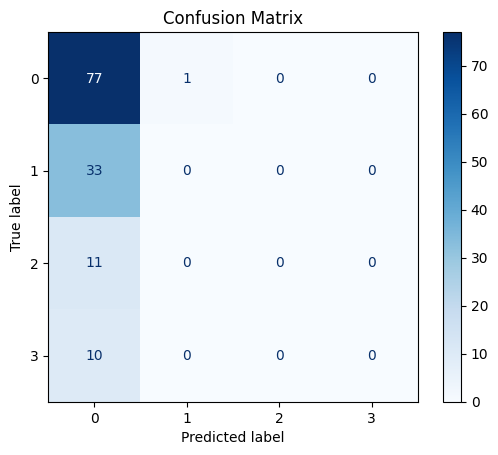

In [53]:
cm = confusion_matrix(y_test, log.predict(X_test))

# Display confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

plt.show()

In [47]:
x_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)
dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [48]:
with torch.no_grad():
    running_vloss = 0.
    avg_loss = 0.
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)

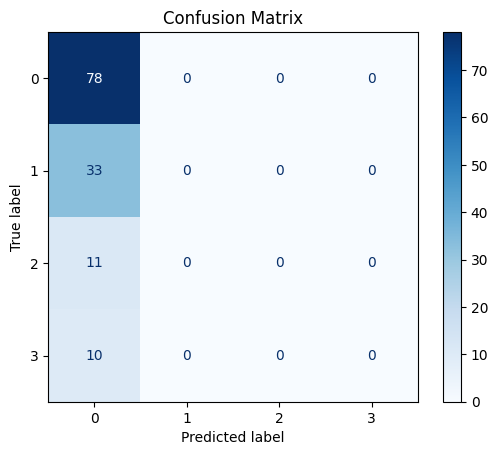

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

## Completeness

In [ ]:
completeness = (
    judge.chat_completion(
        completeness_prompt(output, inputs["question"], inputs["context"]),
        max_tokens=300,
    )
    .choices[0]
    .message.content.lower()
)
completeness_val = int(completeness.split('"completeness": ')[-1][0]) / 5
completeness_val, completeness

In [ ]:
context_relevance = list(
    filter(
        None,
        judge.chat_completion(
            context_statements(inputs["context"], inputs["question"]), max_tokens=400
        )
        .choices[0]
        .message.content.lower()
        .split("statement:"),
    )
)
context_summarized = list(
    filter(
        None,
        judge.chat_completion(summarize_context(inputs["context"]), max_tokens=1000)
        .choices[0]
        .message.content.lower()
        .split("statement:"),
    )
)

In [ ]:
len(context_relevance) / summarized_length(judge, inputs["context"])

In [ ]:
context_relevance